In [26]:
# Project 7 – Sheikh Islam, Wilson Jimenez, Talha Akhlaq
# PyMC implementation of Bayesian Change-Point Model (based on Yıldırım 2012)

import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

Output()

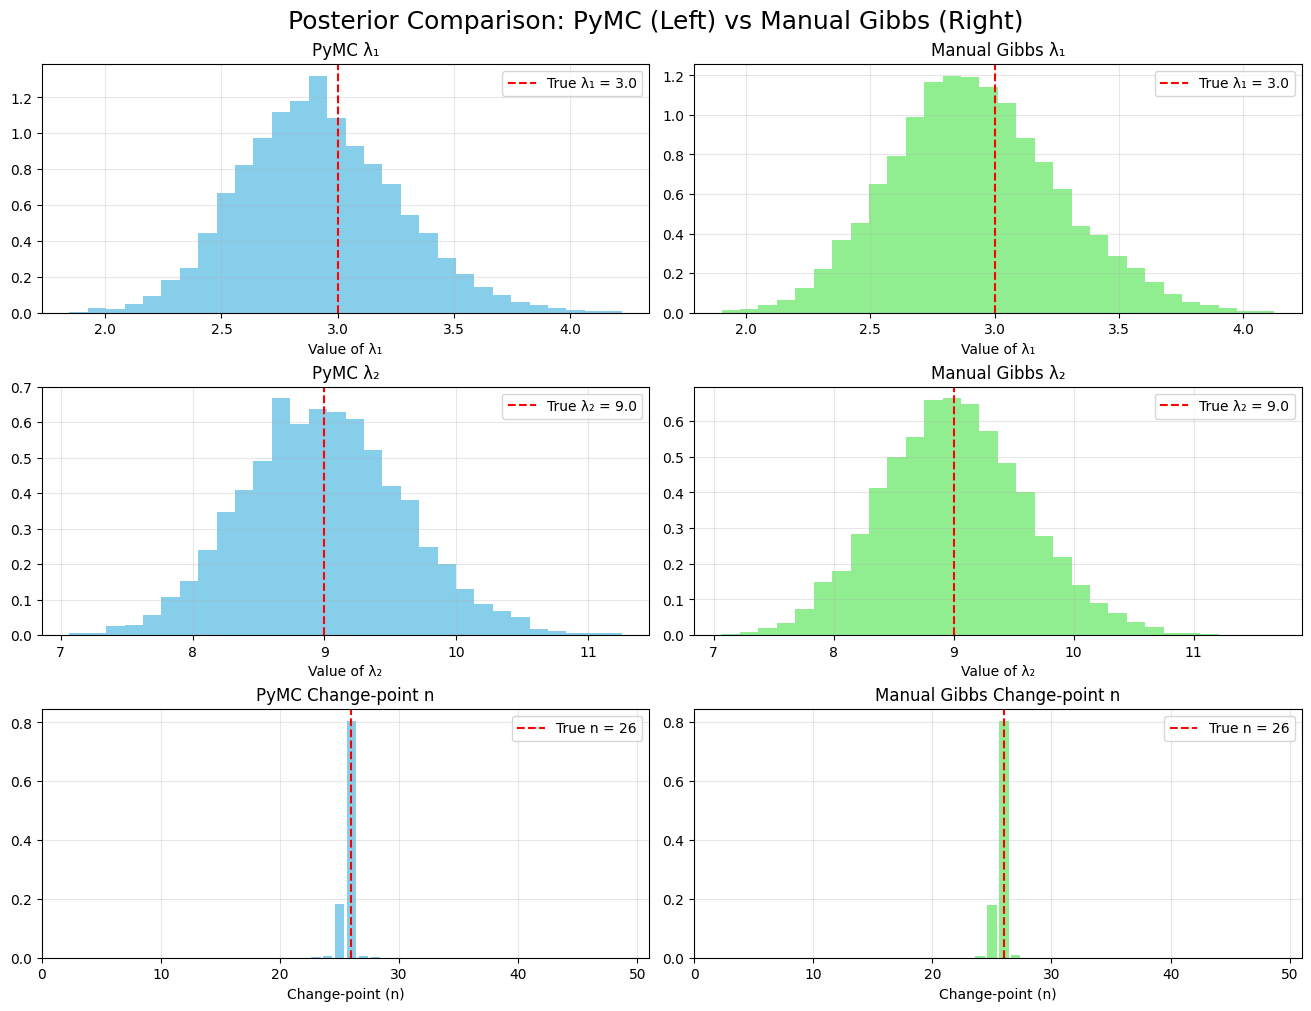

In [27]:
#Pre-defined values from the paper
N = 50
n_true = 26
lambda1_true = 3.0
lambda2_true = 9.0
rng = np.random.default_rng(42)

x = np.where(np.arange(N) < n_true, rng.poisson(lambda1_true, N), rng.poisson(lambda2_true, N))

#Creating a model through pymc to create our lambda predicitions and change point
with pm.Model() as model:
    n = pm.DiscreteUniform('n', lower=1, upper=N)
    λ1 = pm.Gamma('λ1', alpha=2, beta=1)
    λ2 = pm.Gamma('λ2', alpha=2, beta=1)
    μ = pm.math.switch(np.arange(N) < n, λ1, λ2)
    y_obs = pm.Poisson('y', mu=μ, observed=x)
    trace = pm.sample(3000, tune=1000, cores=1, progressbar=True)

#Posterior Plot
λ1_samples = trace.posterior['λ1'].values.ravel()
λ2_samples = trace.posterior['λ2'].values.ravel()
n_samples  = trace.posterior['n'].values.ravel()

fig, axs = plt.subplots(3, 2, figsize=(13, 10), constrained_layout=True)
fig.suptitle("Posterior Comparison: PyMC (Left) vs Manual Gibbs (Right)", fontsize=18)

# PyMc lambda 1
axs[0, 0].hist(λ1_samples, bins=30, density=True, color='skyblue')
axs[0, 0].axvline(lambda1_true, color='red', linestyle='--', label=f'True λ₁ = {lambda1_true}')
axs[0, 0].set_title("PyMC λ₁")
axs[0, 0].set_xlabel("Value of λ₁")
axs[0, 0].grid(alpha=0.3)
axs[0, 0].legend()

# PyMc lambda 2
axs[1, 0].hist(λ2_samples, bins=30, density=True, color='skyblue')
axs[1, 0].axvline(lambda2_true, color='red', linestyle='--', label=f'True λ₂ = {lambda2_true}')
axs[1, 0].set_title("PyMC λ₂")
axs[1, 0].set_xlabel("Value of λ₂")
axs[1, 0].grid(alpha=0.3)
axs[1, 0].legend()

# PyMc change point
axs[2, 0].hist(n_samples, bins=np.arange(0.5, N+1.5), rwidth=0.8, density=True, color='skyblue')
axs[2, 0].axvline(n_true, color='red', linestyle='--', label=f'True n = {n_true}')
axs[2, 0].set_title("PyMC Change-point n")
axs[2, 0].set_xlabel("Change-point (n)")
axs[2, 0].set_xlim(0, N+1)
axs[2, 0].grid(alpha=0.3)
axs[2, 0].legend()

### STRETCH GOAL
a, b          = 2., 1.
burn, draws   = 200, 5_000
λ1, λ2, n     = np.empty(draws+burn), np.empty(draws+burn), np.empty(draws+burn, dtype=int)
λ1[0]         = rng.gamma(a, 1/b); λ2[0] = rng.gamma(a, 1/b); n[0] = rng.integers(1, N+1)
cumsum        = np.cumsum(x);  total = cumsum[-1]

for t in range(1, draws+burn):
    #equation 8 from paper
    s1 = cumsum[n[t-1]-1]
    λ1[t] = rng.gamma(a + s1, 1/(n[t-1] + b))
    # equation 9 from paper
    s2 = total - s1
    λ2[t] = rng.gamma(a + s2, 1/(N - n[t-1] + b))
    # equation 10 from paper
    j   = np.arange(1, N+1)
    logp=  cumsum*np.log(λ1[t]) - j*λ1[t] + (total-cumsum)*np.log(λ2[t]) - (N-j)*λ2[t]
    p   = np.exp(logp - logp.max());  p /= p.sum()
    n[t]= rng.choice(j, p=p)

λ1_gibbs, λ2_gibbs, n_gibbs = λ1[burn:], λ2[burn:], n[burn:]


# Manual lambda 1
axs[0, 1].hist(λ1_gibbs, bins=30, density=True, color='lightgreen')
axs[0, 1].axvline(lambda1_true, color='red', linestyle='--', label=f'True λ₁ = {lambda1_true}')
axs[0, 1].set_title("Manual Gibbs λ₁")
axs[0, 1].set_xlabel("Value of λ₁")
axs[0, 1].legend()
axs[0, 1].grid(alpha=0.3)

# Manual lambda 2
axs[1, 1].hist(λ2_gibbs, bins=30, density=True, color='lightgreen')
axs[1, 1].axvline(lambda2_true, color='red', linestyle='--', label=f'True λ₂ = {lambda2_true}')
axs[1, 1].set_title("Manual Gibbs λ₂")
axs[1, 1].set_xlabel("Value of λ₂")
axs[1, 1].legend()
axs[1, 1].grid(alpha=0.3)

# Manual change point
axs[2, 1].hist(n_gibbs, bins=np.arange(0.5, N+1.5), rwidth=0.8, density=True, color='lightgreen')
axs[2, 1].axvline(n_true, color='red', linestyle='--', label=f'True n = {n_true}')
axs[2, 1].set_title("Manual Gibbs Change-point n")
axs[2, 1].set_xlabel("Change-point (n)")
axs[2, 1].set_xlim(0, N+1)
axs[2, 1].legend()
axs[2, 1].grid(alpha=0.3)

plt.show()